# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [ ]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.v2 as v2 #added v2 based on gemini suggestion

from torchvision import models
from torch.optim.lr_scheduler import OneCycleLR
from datetime import datetime

In [ ]:
# check python version

print(sys.version)

## my venv is pytorch_nanodeg2


3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 17:49:16) [MSC v.1929 64 bit (AMD64)]


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Mean and Std are standard for CIFAR-10
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

# Define transforms
train_transform = v2.Compose([
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD)
])

# Testing pipeline (no augmentation)
test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD)
])
# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2, pin_memory=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2, pin_memory=True)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

c:\Users\rayma\anaconda3\envs\pytorch_nanodeg2\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.8310026].


horse


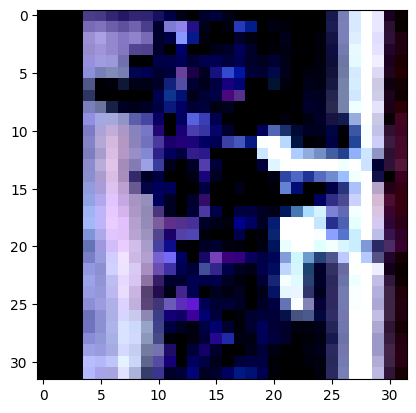

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.7710397].


ship


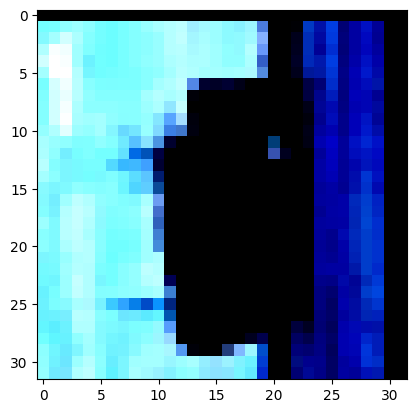

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.2335162].


deer


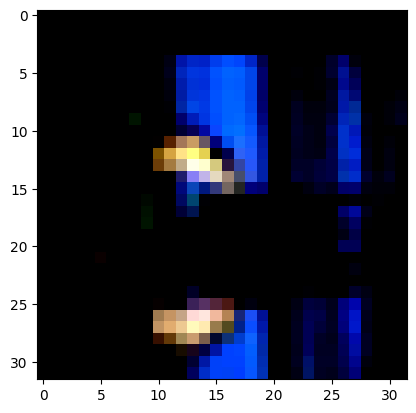

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9659189].


ship


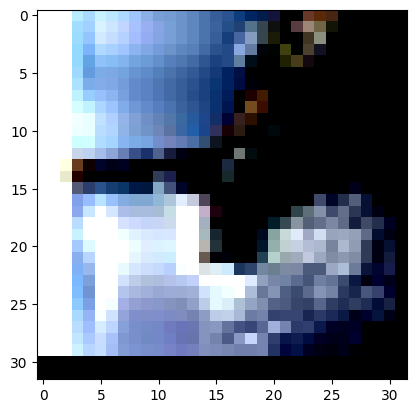

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.7892041].


dog


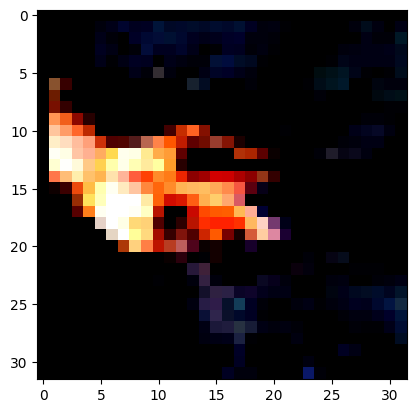

In [5]:
# Explore data
show5(trainloader)
# show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [ ]:
# https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/cifar10-baseline.html



def get_cifar10_resnet18():
    # 1. Load the standard ResNet18 model
    model = models.resnet18(weights=None, num_classes=10)
    
    # 2. Modify the first conv layer (standard is 7x7, stride 2)
    # 3x3 kernel, stride 1, and padding 1 keeps the input at 32x32
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # 3. Replace the maxpool layer with Identity
    # This prevents the initial downsampling to 16x16
    model.maxpool = nn.Identity()
    
    return model

# Usage
device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_cifar10_resnet18().to(device)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [ ]:
#See: https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html#:~:text=CutMix%20and%20MixUp%20are%20popular,of%20this%20pre%2Dprocessing%20pipeline.
# see: https://github.com/shenghaoG/CIFAR10-ResNet18-PyTorch/blob/main/CIFAR10_ResNet18_PyTorch.ipynb
# https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html



# Define Optimizer
# Using SGD with high momentum and standard weight decay
optimizer = optim.SGD(
    model.parameters(), 
    lr=0.1, 
    momentum=0.9, 
    weight_decay=5e-4
)

# Define Scheduler (OneCycleLR)
# This handles the learning rate warmup and decay automatically
epochs = 50
scheduler = OneCycleLR(
    optimizer, 
    max_lr=0.1, 
    steps_per_epoch=len(trainloader), 
    epochs=epochs
)

# Initialize CutMix and MixUp
num_classes = 10
cutmix = v2.CutMix(num_classes=num_classes)
mixup = v2.MixUp(num_classes=num_classes)

# Combine them: randomly choose one for each batch
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

# def train_one_epoch(model, optimizer, train_loader, device):
#     model.train()
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         # 2. Apply advanced augmentation to the batch
#         # This converts labels to a soft distribution (shape: [batch_size, 10])
#         images, labels = cutmix_or_mixup(images, labels)

#         optimizer.zero_grad()
#         outputs = model(images)
        
#         # 3. Use functional cross_entropy to handle soft labels
#         loss = F.cross_entropy(outputs, labels)
        
#         loss.backward()
#         optimizer.step()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [ ]:
## Same as below but with checkpointing

checkpoint_path = "latest_checkpoint.pth"
start_epoch = 0
train_losses, val_losses, val_accuracies = [], [], []

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint: {checkpoint_path}")
    # weights_only=True is a 2024/2025 best practice for security
    checkpoint = torch.load(checkpoint_path, weights_only=False) 
    
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    scheduler.load_state_dict(checkpoint['scheduler_state'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    val_accuracies = checkpoint['val_accuracies']
    print(f"Resuming from epoch {start_epoch + 1}")

def save_checkpoint(epoch):
    state = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
    }
    torch.save(state, checkpoint_path)
    print(f"--- Checkpoint saved at epoch {epoch+1} ---")

# 2. TRAINING LOOP with Interruption Handling
try:
    for epoch in range(start_epoch, epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            images, labels = cutmix_or_mixup(images, labels)

            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_train_loss += loss.item() * images.size(0)

        # --- VALIDATION PHASE ---
        model.eval()
        running_val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Log metrics
        avg_train_loss = running_train_loss / len(trainloader.dataset)
        avg_val_loss = running_val_loss / len(testloader.dataset)
        val_accuracy = 100 * correct / total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
        
        # 3. PERIODIC SAVE: Save every epoch (or every N epochs)
        save_checkpoint(epoch)

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving final state...")
    save_checkpoint(epoch)
    print("Safe to exit.")

In [ ]:
# import torch

# Metrics tracking
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    running_train_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        # Apply training augmentations (CutMix/MixUp)
        images, labels = cutmix_or_mixup(images, labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_train_loss += loss.item() * images.size(0)

    # --- VALIDATION PHASE ---
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    correct = 0
    total = 0

    # No gradients needed for validation (saves memory)
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            
            running_val_loss += loss.item() * images.size(0)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Log metrics
    avg_train_loss = running_train_loss / len(trainloader.dataset)
    avg_val_loss = running_val_loss / len(testloader.dataset)
    val_accuracy = 100 * correct / total
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.2f}%")


Epoch [1/50] | Train Loss: 2.0045 | Val Loss: 1.6201 | Val Acc: 41.73%
Epoch [2/50] | Train Loss: 1.8208 | Val Loss: 1.4115 | Val Acc: 50.47%
Epoch [3/50] | Train Loss: 1.7278 | Val Loss: 1.1142 | Val Acc: 61.80%
Epoch [4/50] | Train Loss: 1.6616 | Val Loss: 1.0524 | Val Acc: 64.63%
Epoch [5/50] | Train Loss: 1.5535 | Val Loss: 0.9368 | Val Acc: 69.22%
Epoch [6/50] | Train Loss: 1.4845 | Val Loss: 0.8258 | Val Acc: 73.37%
Epoch [7/50] | Train Loss: 1.4402 | Val Loss: 0.8086 | Val Acc: 75.80%
Epoch [8/50] | Train Loss: 1.4107 | Val Loss: 0.7521 | Val Acc: 76.59%
Epoch [9/50] | Train Loss: 1.3704 | Val Loss: 0.6713 | Val Acc: 80.95%
Epoch [10/50] | Train Loss: 1.3366 | Val Loss: 0.6718 | Val Acc: 79.54%
Epoch [11/50] | Train Loss: 1.3414 | Val Loss: 0.6710 | Val Acc: 79.37%


Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
# import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, val_accuracies):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot 1: Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, 'g-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Execution
plot_training_history(train_losses, val_losses, val_accuracies)



NameError: name 'train_losses' is not defined

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get index of the highest probability prediction
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy on CIFAR-10: {accuracy:.2f}%')
    return accuracy

# Run the test
final_accuracy = test_model(model, testloader, device)


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
# from datetime import datetime
# import torch

# Generate a timestamp (e.g., '20251217_2206')
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Define the unique filename with a key metric
# Assuming val_accuracy is a variable from your testing loop
filename = f"cifar10_resnet18_{timestamp}_acc{val_accuracy:.2f}.pth"

# 3. Save the state dictionary
torch.save(model.state_dict(), filename)
print(f"Model saved as: {filename}")

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**

